In [99]:



%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras
import mlflow
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt 

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from common_params import input_shape, img_dir, model_dir, data_dir, npy_dir
from common_img_functions import read_img
from common_plots import display_images
from common_plots import plot_img
from label_names import label30
from data_load import prepare_subfolder_extract
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from classification_plot import plot_classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load model


In [33]:
mlflow_run_id = "c072a9d08cc44c91a1b714b7fe396406"

In [34]:
data, info = mlflow.get_run(mlflow_run_id)
NB_CLASS = int(data[1].tags["NB_CLASS"])
NB_IMG_PER_CLASS =int( data[1].tags["NB_IMG_PER_CLASS"])

In [35]:
# Logged model in MLFlow
save_dir = os.path.join(model_dir, mlflow_run_id)
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(save_dir)

In [36]:
NB_IMG_PER_CLASS

100

In [37]:
list_of_folder = np.load(os.path.join(npy_dir,"top_breed_folder_list_30.npy"),  allow_pickle=True)
_, test_dir = prepare_subfolder_extract(NB_IMG_PER_CLASS, NB_CLASS, list_of_folder) 

In [38]:
label_name30 = [ name_folder.split("-")[1] for name_folder in label30]

In [39]:
test_dir = os.path.join(data_dir,"images_subset","test")

test_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(input_shape[0],input_shape[1]) )

Found 681 files belonging to 30 classes.


In [40]:
loaded_model.output_shape

(None, 30)

In [41]:
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print('Accuracy on test dataset:', test_accuracy)

681/681 [==============================] - 52s 76ms/step - loss: 1.4183 - accuracy: 0.7298
Accuracy on test dataset: 0.7298091053962708


In [42]:
# save test metrics
with mlflow.start_run(run_id=mlflow_run_id):
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy",test_accuracy)


In [43]:
test_img = read_img(os.path.join(data_dir , "extracted\\test\\n02085936-Maltese_dog\\n02085936_233_0.jpg"))
test_imge = np.expand_dims(test_img, axis=0)
class_names_from_folder = [ name.split('-')[1] for name in label30 ]
predictions = loaded_model.predict(test_imge)[0]
print(f"This image as a probability {round(100*predictions[0],2)}% \
    {class_names_from_folder[0]} of and a probability { round(100*predictions[1],2)}% of {class_names_from_folder[1]}")

This image as a probability 100.0%     Maltese_dog of and a probability 0.0% of Shih


True label : Siberian_husky
Predicted  : Siberian_husky


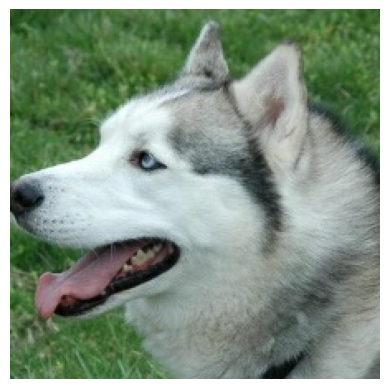

In [44]:
for img, label in test_ds.take(1):
    label_idx = np.argmax(label)
    print(f"True label : {label_name30[label_idx]}")
    
    prediction = loaded_model.predict(img)
    y_pred = np.argmax(prediction)
    print(f"Predicted  : {label_name30[y_pred]}")

    plot_img( img[0].numpy().astype("uint8"))
    

In [46]:


# Initialize empty lists to accumulate true labels and predictions
true_labels = []
predicted_labels = []
img_set = []
label_set = []
# Iterate over the test dataset
for img, label in test_ds.take(600):
    true_labels.extend(np.argmax(label.numpy(), axis=1))  # Convert one-hot label to class index
    prediction = np.argmax(loaded_model.predict(img, verbose=0), axis=1)
    predicted_labels.extend(prediction)

    img_set.append(img)
    label_set.append(label)
# Convert accumulated lists to numpy arrays
y_true = np.array(true_labels)
y_pred = np.array(predicted_labels)



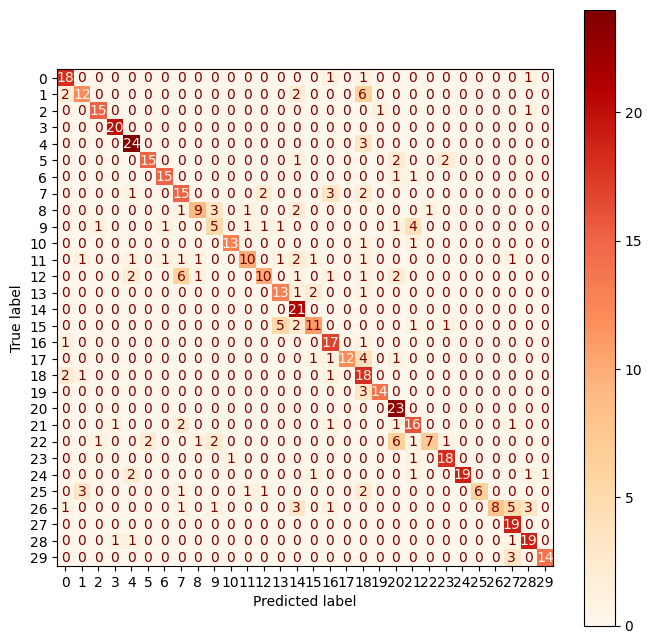

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels = np.arange(NB_CLASS))
cmp = ConfusionMatrixDisplay(conf_matrix)


fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax,cmap= "OrRd")
plt.show()

In [94]:
def get_wrong_label_imgs(label_idx) : 

    nb = len(label_set)

    fp_predictions  = []
    to_be_displayed = []
    for i in range(nb) : 
        breedidx = np.argmax(label_set[i].numpy(), axis=1)[0]
        if breedidx == label_idx : 

            predicted = np.argmax(loaded_model.predict(img_set[i], verbose=0), axis=1)[0]
            if predicted != label_idx : 
                to_be_displayed.append(img_set[i][0].numpy().astype("uint8")) 
                fp_predictions.append(predicted)

    return to_be_displayed, fp_predictions



In [109]:
def display_9_fp(id) : 
    to_be_displayed, fp_predictions = get_wrong_label_imgs(id)
    display_images(to_be_displayed,3,3,from_path=False, main_title=f"{label_name30[id]} wrongly classified", titles = [label_name30[k] for k in fp_predictions])

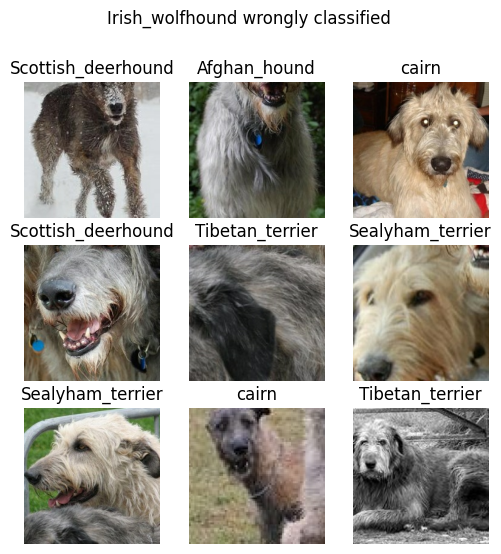

In [110]:
display_9_fp(7)

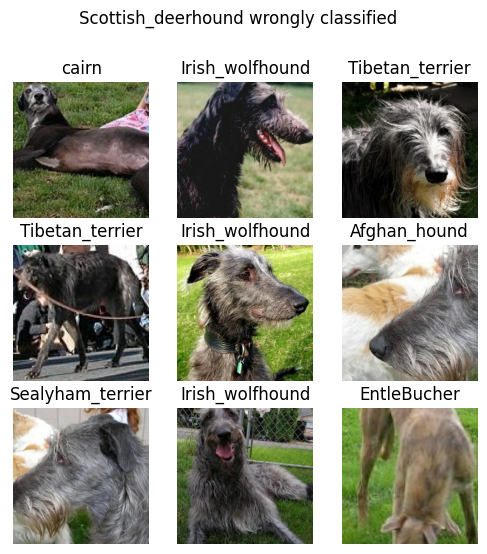

In [111]:
display_9_fp(12)

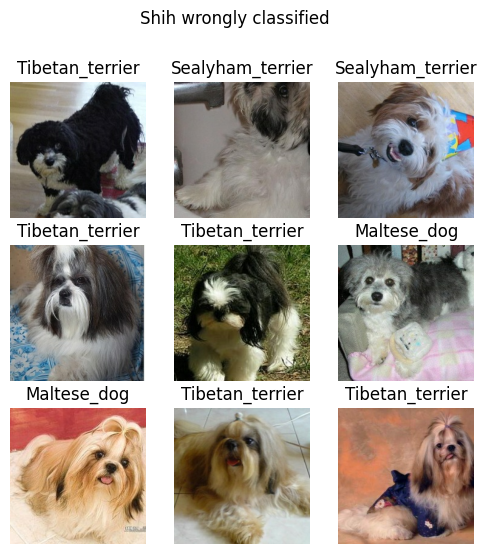

In [112]:
display_9_fp(1)

Very sensitive to color beagle(white, brown and black), airedale same issue. 

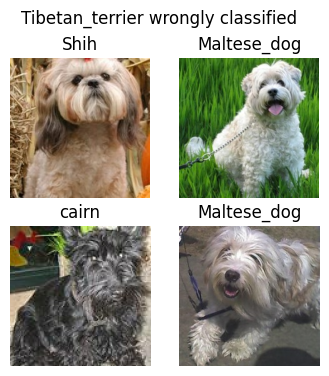

In [114]:
id = 18 
to_be_displayed, fp_predictions = get_wrong_label_imgs(id)
display_images(to_be_displayed,2,2,from_path=False, main_title=f"{label_name30[id]} wrongly classified", titles = [label_name30[k] for k in fp_predictions])

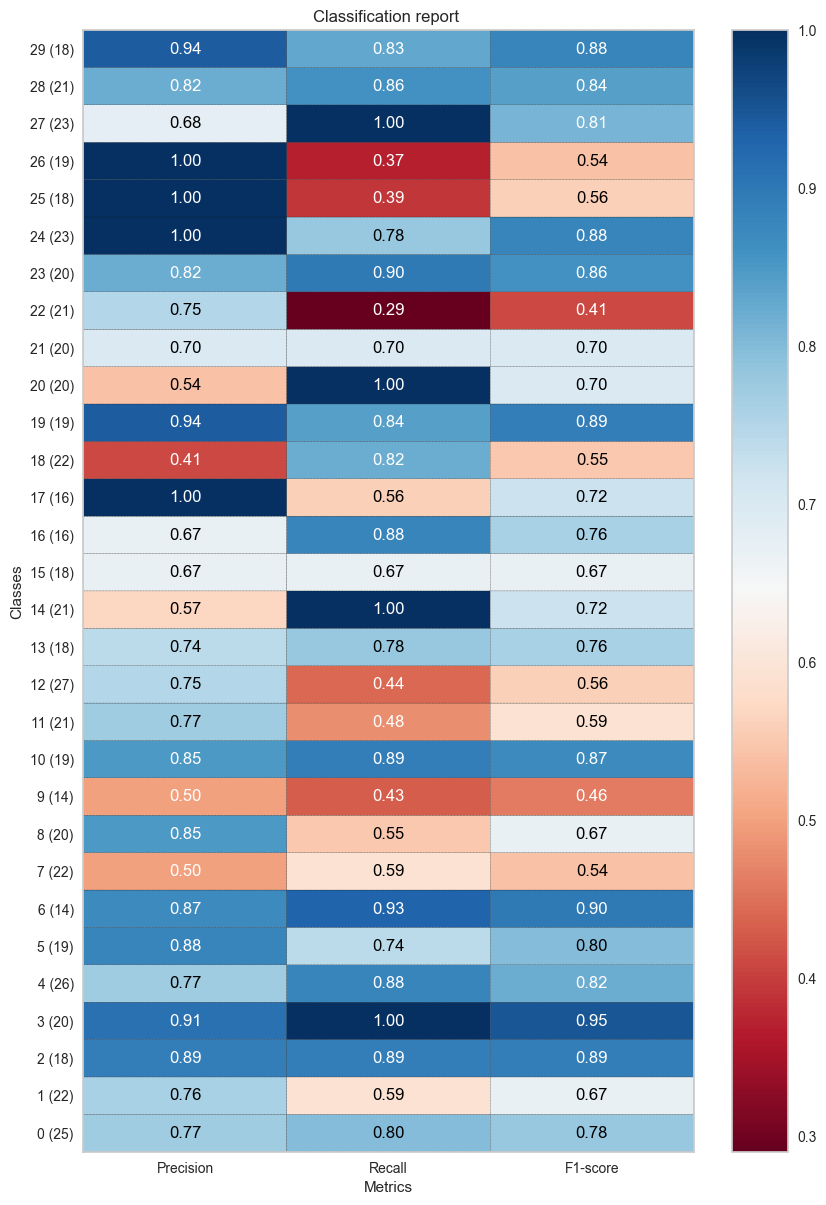

In [134]:
cr = classification_report(y_true, y_pred)
plot_classification_report(cr)

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        20
           1       0.45      0.67      0.54        21
           2       0.69      0.90      0.78        20
           3       0.28      1.00      0.44        17
           4       1.00      0.85      0.92        27
           5       0.73      0.44      0.55        18
           6       1.00      0.88      0.94        17
           7       0.74      0.56      0.64        25
           8       0.77      0.48      0.59        21
           9       0.56      0.82      0.67        17
          10       0.76      0.84      0.80        19
          11       0.64      0.47      0.55        19
          12       0.77      0.61      0.68        28
          13       0.41      0.72      0.52        18
          14       1.00      0.55      0.71        20
          15       0.92      0.55      0.69        20
          16       0.54      0.82      0.65        17
          17       0.64    

In [ ]:
for test_images, test_labels in test_ds.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = loaded_model.predict(test_images)

1/1 [==============================] - 0s 94ms/step


In [ ]:
test_images_re = test_images.reshape(input_shape)

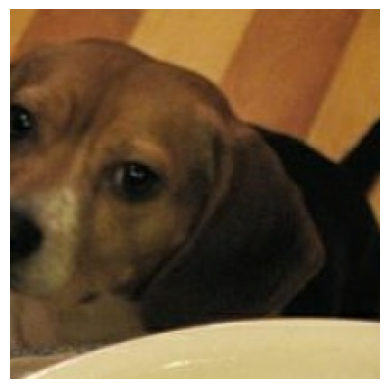

In [ ]:
plt.axis("off")
plt.imshow(np.array(test_images[0],np.int32))
plt.show()